In [106]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker
from skimage import measure

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm.notebook import tqdm


def load_slice_data(path, heart, slice_name, subdir, n_angular, n_radial,
                    node_step):
    # Load slice and build HeartSlice object
    heart_slice_builder = HeartSliceBuilder()
    heart_slice_builder.build_from_file(path, heart, slice_name,
                                        n_angular, n_radial, node_step)
    heart_slice = heart_slice_builder.heart_slice

    # Load stats
    path_slice_stats = path.joinpath(heart, subdir, slice_name)
    stats_loader = StatsLoader(path)
    object_stats = stats_loader.load_slice_data(path_slice_stats)

    # Build objects properties
    objects_props_builder = ObjectsPropertiesBuilder()
    objects_props_builder.build_from_stats(object_stats, min_area=1)
    objects_props_builder.add_slice_props(heart_slice)
    df = objects_props_builder.objects_props
    # df['perimeter'] = df['image'].apply(
    #     lambda x: measure.perimeter(x, neighbourhood=4))
    # df['complexity'] = df['perimeter'] ** 2 / (4 * np.pi * df['area'])

    df['location'] = pd.cut(df['segment_labels'],
                            bins=np.linspace(0, n_angular * n_radial,
                                             n_radial + 1),
                            labels=['SUB-ENDO', 'MID', 'SUB-EPI'])
    df['heart'] = heart
    return df.loc[:, ['heart', 'segment_labels',
                      'solidity', 'area', 'location']]


def load_heart_data(heart, path, subdir, n_angular, n_radial, node_step):
    path_ = path.joinpath(heart, 'Stats')
    files = list(path_.glob('*{}'.format('.pkl')))
    files = sorted([file.stem for file in files if not file.name.startswith('.')])
    
    data = []
    for slice_name in tqdm(files):
        df = load_slice_data(path, heart, slice_name, subdir, n_angular, 
                             n_radial, node_step)
        data.append(df)

    return pd.concat(data)


In [163]:
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
n_angular = 12
n_radial = 3
node_step = 3

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']
subdir = 'Stats'


data = {}

for heart in hearts:
    data[heart] = load_heart_data(heart, path, subdir, n_angular, n_radial,
                                  node_step)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [164]:
data_gen = {}

for heart in hearts:
    data_gen[heart] = load_heart_data(heart, path, 'StatsGenerated', n_angular,
                                      n_radial, node_step)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [168]:
data_gen_all = pd.concat(data_gen.values())

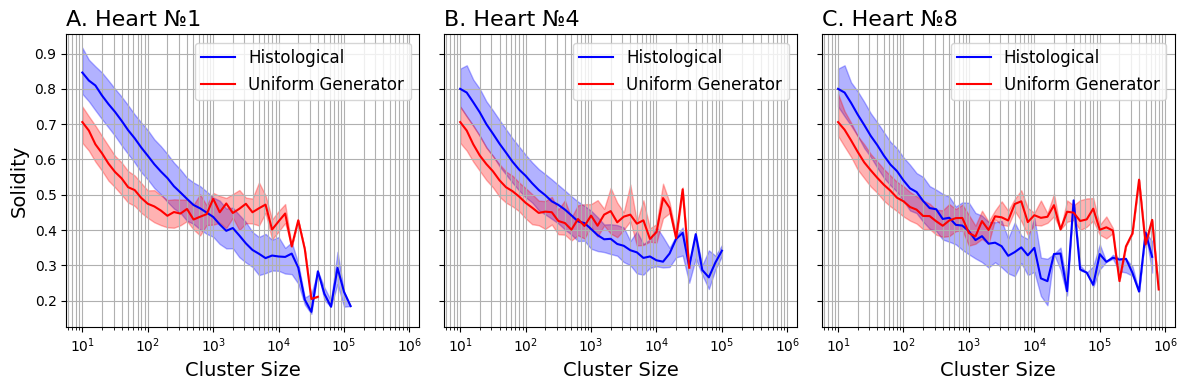

In [179]:
def quartiles(data):
    data_stats = data.groupby(['area_bins'], observed=True).describe()
    x = data_stats.index
    medians = data_stats[('solidity', '50%')]
    medians.name = 'solidity'
    quartiles1 = data_stats[('solidity', '25%')]
    quartiles3 = data_stats[('solidity', '75%')]
    return x, medians.values, quartiles1.values, quartiles3.values


titles = ['A', 'B', 'C']
heart_labels = [f'Heart №{i}' for i in [1, 4, 8]]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for i, heart in enumerate(hearts):
    data_ = data[heart]
    data_gen_ = data_gen[heart]

    area_bins = np.geomspace(10, 1e6, 51)

    data_['area_bins'] = pd.cut(data_['area'], bins=area_bins)
    data_gen_['area_bins'] = pd.cut(data_gen_['area'], bins=area_bins)

    x, medians, quartiles1, quartiles3 = quartiles(data_)
    x_gen, medians_gen, quartiles1_gen, quartiles3_gen = quartiles(data_gen_)

    axs[i].plot(area_bins[x.codes], medians, color='blue',
                label='Histological')
    axs[i].fill_between(area_bins[x.codes], quartiles1, quartiles3, alpha=0.3,
                        color='blue')
    axs[i].plot(area_bins[x_gen.codes], medians_gen, color='red',
                label='Uniform Generator')
    axs[i].fill_between(area_bins[x_gen.codes], quartiles1_gen, 
                        quartiles3_gen, alpha=0.3, color='red')
    axs[i].set_title(f'{titles[i]}. {heart_labels[i]}',
                     loc='left', fontsize=16)
    axs[i].legend(loc='upper right', fontsize=12)

for ax in axs:
    ax.set_xscale('log')
    ax.grid(which='both')
    ax.set_xlabel('Cluster Size', fontsize=14)
axs[0].set_ylabel('Solidity', fontsize=14)
plt.tight_layout()
# plt.yscale('log')
plt.show()

In [180]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('solidity.png'),
            dpi=300, bbox_inches='tight')

In [85]:
df = data[data['area'] < 200]

area_bins = np.arange(df['area'].min(),
                      1 + df['area'].max())
complexity_bins = np.arange(df['complexity'].min(), 
                            1 + df['complexity'].max())


hist, _, _ = np.histogram2d(df['area'], df['complexity'], bins=[area_bins, 
                                                              complexity_bins])
hist = hist.T
hist.shape

(11, 189)

In [92]:
y = (hist / hist.sum(axis=0)[np.newaxis, :])

y = np.cumsum(y[::-1, ::-1], axis=0)[::-1, ::-1]

# y = np.cumsum(np.cumsum(hist[::-1, ::-1], axis=0), axis=1)[::-1, ::-1]
# y = np.where(y == 0, 0, np.log(y))

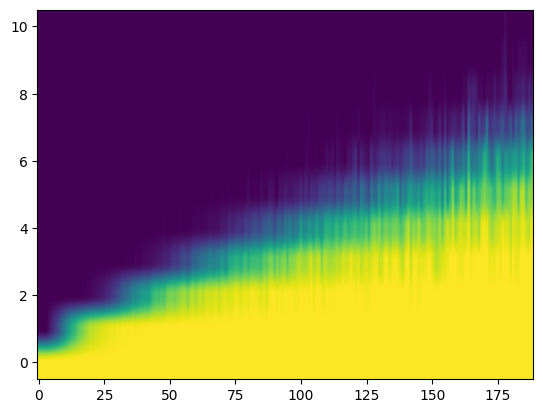

In [93]:
plt.figure()
plt.imshow(y, cmap='viridis', origin='lower', aspect='auto')
plt.show()

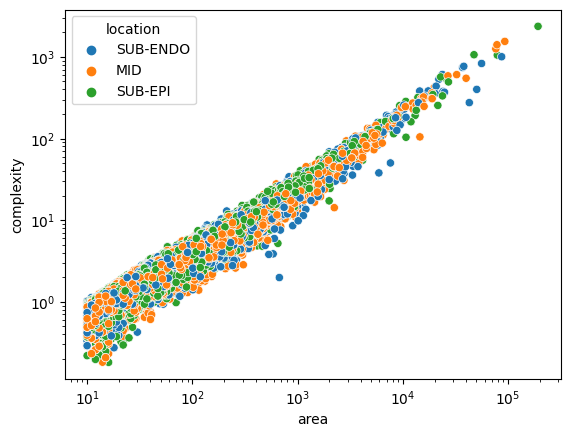

In [30]:
import seaborn as sns


def calc_cdf(df):
    count = np.bincount(df['area'].values, weights=df['complexity'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]

    return area_bins, count.cumsum() / count.sum()


plt.figure()
sns.scatterplot(data=data, x='area', y='complexity', hue='location')
plt.xscale('log')
plt.yscale('log')
plt.show()